# Manuscript Image Similarity

This notebook implements image similarity calculation with downloaded manuscript images.

Load Model and define function

In [46]:
import torch
import timm

image_model = timm.create_model('resnet50', pretrained=True, num_classes=0)
image_model.eval() # this turns off dropout etc, important!


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act3): ReLU(inplace=True)
      (downsample): Sequen

Load manuscript images

In [47]:
import numpy as np
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
manuscript_dataset = datasets.ImageFolder('../data/cats_and_dogs/', transform=transform)
manuscript_label_to_name =  {value:key for key, value in manuscript_dataset.class_to_idx.items()}

manuscript_dataloader = torch.utils.data.DataLoader(manuscript_dataset, batch_size=32, shuffle=False)

image_batch, label_batch = next(iter(manuscript_dataloader))

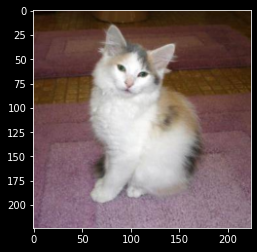

In [48]:
import matplotlib.pyplot as plt

def plot_image(image_tensor):
    plt.imshow(image_tensor.permute(1, 2, 0))
    plt.show()
plot_image(image_batch[0])


Calculate manuscript vectors

In [49]:
manuscript_vectors = []
manuscript_labels = []
for batch_of_images, batch_of_labels in manuscript_dataloader:
    batch_of_vectors = image_model(batch_of_images)
    manuscript_vectors.append(batch_of_vectors)
    manuscript_labels.append(batch_of_labels)
    
manuscript_vectors = torch.cat(manuscript_vectors)
manuscript_labels = torch.cat(manuscript_labels)

Make a dataframe

In [57]:
import pandas as  pd

manuscript_dataframe = pd.DataFrame({'vector': [x for x in manuscript_vectors.detach().numpy()], 'label': manuscript_labels.detach().numpy()})
manuscript_dataframe['manuscript'] = [manuscript_label_to_name[label] for label in manuscript_dataframe['label']]
manuscript_groups = manuscript_dataframe.groupby(by='manuscript')

Visualise similarity between one particular image and the whole dataset

In [54]:
from scipy import spatial

def cosine_similarity(vector1, vector2):
    return 1 - spatial.distance.cosine(vector1, vector2)

index = 0

row_for_this_image = manuscript_dataframe.iloc[index]
vector_for_this_image = row_for_this_image['vector']
manuscript_for_this_image = row_for_this_image['manuscript']

# rows_from_the_same_manuscript = manuscript_groups.get_group(manuscript_for_this_image).copy()

manuscript_dataframe['cosine'] = manuscript_dataframe['vector'].apply(lambda x: cosine_similarity(x, vector_for_this_image))
print(manuscript_dataframe[['manuscript', 'cosine']])

  manuscript    cosine
0       cats  1.000000
1       cats  0.585926
2       cats  0.581423
3       cats  0.579747
4       cats  0.618149
5       cats  0.680757
6       dogs  0.236813
7       dogs  0.244604
8       dogs  0.365695
9       dogs  0.256154


Visulise the similarity between images from the same manuscript

In [55]:
index = 0

row_for_this_image = manuscript_dataframe.iloc[index]
vector_for_this_image = row_for_this_image['vector']
manuscript_for_this_image = row_for_this_image['manuscript']

rows_from_the_same_manuscript = manuscript_groups.get_group(manuscript_for_this_image).copy()

rows_from_the_same_manuscript['cosine'] = rows_from_the_same_manuscript['vector'].apply(lambda x: cosine_similarity(x, vector_for_this_image))
print(rows_from_the_same_manuscript[['manuscript', 'cosine']])

  manuscript    cosine
0       cats  1.000000
1       cats  0.585926
2       cats  0.581423
3       cats  0.579747
4       cats  0.618149
5       cats  0.680757


Visualise similarity between image and a different manuscript

In [60]:
index = 0

row_for_this_image = manuscript_dataframe.iloc[index]
vector_for_this_image = row_for_this_image['vector']
manuscript_for_this_image = row_for_this_image['manuscript']

manuscript_name = 'dogs'
rows_from_the_different_manuscript = manuscript_groups.get_group(manuscript_name).copy()

rows_from_the_different_manuscript['cosine'] = rows_from_the_different_manuscript['vector'].apply(lambda x: cosine_similarity(x, vector_for_this_image))
print(rows_from_the_different_manuscript[['manuscript', 'cosine']])

  manuscript    cosine
6       dogs  0.236813
7       dogs  0.244604
8       dogs  0.365695
9       dogs  0.256154
